In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
%matplotlib inline
import sys
import os
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter, fitness
from matplotlib import colors
from spatialentropy import leibovici_entropy, altieri_entropy
from datetime import date
from scipy.ndimage import convolve

KeyboardInterrupt: 

In [ ]:
sys.path.append("./utils")
from DoseResponseModel import DoseResponseModel

jarFileName = "./HAL_dose_response_pc9.jar"

# consumpt_rate = [10**-4,0.001,0.01,0.1,0.5]
# consumpt_rate = [0.01]

indx = 0
n_replicates = 4
drug_conc_scale = 1
dt = 12

# get today's date
today = date.today()

date_str = today.strftime("%Y-%m-%d")

data_folder = "./data/pc9_pulse_dosing/" + date_str

char_length = [1,2.5,5,10]

pulse_duration = 7*24 # hours
pulse_interval = 2*7*24 # hours 
drugStopTime = 7*24*8 # hours
simulation_length = 7*24*12 # hours
dt = 2

nTSteps = int(simulation_length/dt)


cmap = sns.color_palette("colorblind", as_cmap=True)[0:4]
# cmap_msw = ListedColormap(cmap)
cmap_agent = ListedColormap(['black'] + cmap)
cmap_msw = ListedColormap(['slategray'] + cmap)
# cmap_msw = ListedColormap(sns.color_palette("colorblind", as_cmap=True))
cmap_charlength = sns.color_palette("colorblind", as_cmap=True)[5:9]
# cmap_charlength = ListedColormap(cmap_charlength)

dr_params = {
    'gmax':[0.0393, 0.0376, 0.0360, 0.0355],
    'gmin':[0.0179, 0.0286, 0.0337, 0.0296],
    'hc':[2.18, 2.19, 17.45, 1.85],
    'ic50':[0.0333, 0.0371, 0.020, 0.0530]
}

def hill_fn(conc,gmax, gmin, ic_50, hc):
    
    y = gmax + ((gmin - gmax) * conc**hc) / (ic_50**hc + conc**hc)
    return y

def gen_fit_land(conc,gmax,gmin,ic50,hc):
    fl = []

    for g in range(len(gmax)):
        fl.append(hill_fn(conc,gmax[g],gmin[g],ic50[g],hc[g]))
    return fl

def get_most_fit_at_conc(data):
    most_fit = np.zeros(data.shape)
    for z in range(data.shape[0]):
        for j in range(data.shape[1]):
            # conc = 10**data[z,j]
            conc = data[z,j]
            p_fit_list = gen_fit_land(conc,**dr_params)
            most_fit[z,j] = int((np.argmax(p_fit_list)))
    return most_fit

In [ ]:
for cl in char_length:

    modelConfigDic = {"xDim":100,"yDim":100,"nTSteps":nTSteps,"saveModelState":True,
                    "imageFrequency":-1,"nReplicates":n_replicates,
                    "dt":dt,"initialGeometry":"circle","initialDensity":1,
                    "initialWidth":10,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
                    "threeParamHill":False,"dieProb":0.025,"drugConcScale":drug_conc_scale,
                    "mutProb":0.001,
                    "staticGrid":True,"srcConc":10,"charLength":cl,
                    "pulseDosing":True,"staticGrid":True,"pMutant":0.1,
                    # "pulseDuration":24*3,"useMaxConc":True
                    "pulseDuration":pulse_duration,"pulseInterval":pulse_interval,
                    "useMaxConc":True,"drugStopTime":drugStopTime}
    
    # make sure each key is unique


    dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
    imgDir = "./data/doseResponseImages"

    myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
    myModel.Simulate()
    indx += 1

/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_27817/2045679395.py:81: RuntimeWarning: invalid value encountered in divide
  prop_resistant.append(resistant_cells[j]/total_cells[j])
/var/folders/zc/70qypfn92xg4qzzd0ldt5ks80000gn/T/ipykernel_27817/2045679395.py:83: RuntimeWarning: Mean of empty slice
  prop_resistant_mean = np.nanmean(prop_resistant,axis=0)
/Users/eshanking/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


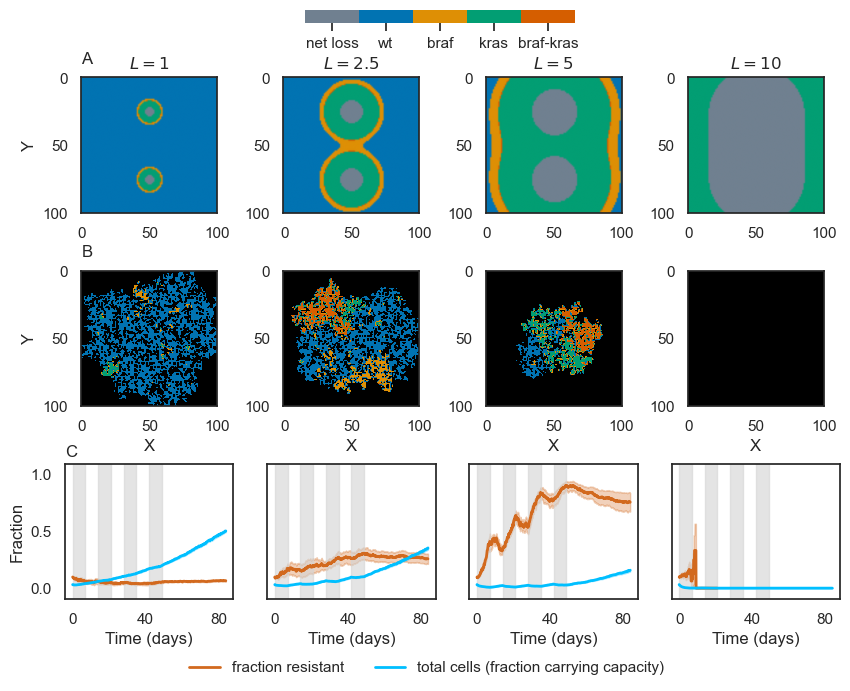

In [ ]:
fig,ax_list = plt.subplots(ncols=len(char_length),nrows=3,figsize=(10,6))

total_cells_list = []
resistant_cells_list = []

for i,cl in enumerate(char_length):
    ax = ax_list[0,i]
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    # load the diffGrid

    diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
    diffGrid = pd.read_csv(diffGridFile)
    img_t = np.zeros((100,100))

    img_t[diffGrid['x'],diffGrid['y']] = diffGrid['field']*drug_conc_scale

    diffImg = img_t
    msw = get_most_fit_at_conc(img_t)

    msw[img_t>1] = -1

    ax.imshow(msw,cmap=cmap_msw,vmin=-1,vmax=3,
              interpolation='gaussian',interpolation_stage='rgba')

    ax = ax_list[1,i]

    dataFile = dataDir + '/RepId_0_popGrid.csv'
    data = pd.read_csv(dataFile)
    img_t = np.ones((100,100))*-1
    img_t[data['x'],data['y']] = data['genotype']
    
    ax.imshow(img_t,cmap=cmap_agent,vmin=-1,vmax=3)

    ax = ax_list[2,i]
    counts_dict = {}

    for j in range(n_replicates):
        dataFile = dataDir + '/RepId_{}.csv'.format(j)
        data = pd.read_csv(dataFile)
        time = np.array(data["Time"])

        gen_indx = 0
        for col in data.columns[3:7]:
            ts = data[col]

            if gen_indx not in counts_dict:
                counts_dict[gen_indx] = np.array([ts])
            else:
                counts_dict[gen_indx] = np.append(counts_dict[gen_indx],np.array([ts]),axis=0)

            gen_indx += 1
    
    count_list = []
    # total_cells = np.zeros(data['Time'].shape)
    # resistant_cells = np.zeros(data['Time'].shape)
    wt_cells = []
    resistant_cells = [] # t by n array

    for j in range(n_replicates):
        resistant_cells_t = np.zeros(data['Time'].shape)
        for gen_indx in counts_dict.keys():
            ts = counts_dict[gen_indx][j]
            if gen_indx == 0:
                wt_cells.append(ts)
            else:
                # resistant_cells.append(ts)
                resistant_cells_t += ts
        resistant_cells.append(resistant_cells_t)
        

    
    wt_cells = np.array(wt_cells)
    resistant_cells = np.array(resistant_cells)

    total_cells = wt_cells + resistant_cells

    prop_resistant = []

    # need to deal with the fact that total cells can be zero
    for j in range(n_replicates):
        prop_resistant.append(resistant_cells[j]/total_cells[j])

    prop_resistant_mean = np.nanmean(prop_resistant,axis=0)
    prop_resistant_err = np.nanstd(prop_resistant,axis=0)/np.sqrt(n_replicates)

    ax.plot(data['Time'],prop_resistant_mean,linewidth=2,color='chocolate',label='fraction resistant')
    ax.fill_between(data['Time'],prop_resistant_mean-prop_resistant_err,prop_resistant_mean+prop_resistant_err,alpha=0.3,color='chocolate')
    
    total_cells_mean = np.nanmean(total_cells,axis=0)
    total_cells_err = np.nanstd(total_cells,axis=0)/np.sqrt(n_replicates)

    ax.plot(data['Time'],total_cells_mean/10**4,linewidth=2,color='deepskyblue',label='total cells (fraction carrying capacity)')
    ax.fill_between(data['Time'],(total_cells_mean-total_cells_err)/10**4,(total_cells_mean+total_cells_err)/10**4,alpha=0.3,color='deepskyblue')

    # fill vertically when the drug is on
    time = np.array(data['Time'])
    for t_start in np.arange(0,drugStopTime,pulse_interval):
        t_end = t_start + pulse_duration
        ax.fill_between([t_start,t_end],[-100,-100],[10000,10000],color='lightgrey',alpha=0.6)
    
    # ax.set_yscale('log')
    ax.set_ylim([-0.1,1.1])
    # ax.set_ylim([1,6000])
    # change xticks to days
    time = np.array(data['Time'])
    ax.set_xticks(np.arange(0,np.max(time),40*24))
    ax.set_xticklabels((np.arange(0,np.max(time),40*24)/24).astype(int))
    ax.set_xlabel('Time (days)')

ax_list[1,0].set_ylabel('Y')
ax_list[0,0].set_ylabel('Y')

for ax in ax_list[1,:]:
    ax.set_xlabel('X')

for ax in ax_list.flatten()[0:8]:
    ax.set_xticks([0,50,100])
    ax.set_yticks([0,50,100])

cbar_ax = fig.add_axes([0.25, 0.97, 0.5, 0.15])

norm = plt.Normalize(vmin=-1, vmax=3)
scalar_mappable = cm.ScalarMappable(cmap=cmap_msw, norm=norm)
scalar_mappable.set_array([])

cbar = plt.colorbar(scalar_mappable, ticks=[-0.6,.2,1,1.8,2.6], ax=cbar_ax, 
                    orientation='horizontal')

cbar.set_ticklabels(['net loss','wt','braf','kras','braf-kras'])
cbar.outline.set_visible(False)
cbar_ax.set_visible(False)

# shift rows 1 and 2 down
for row in [1,2]:
    for ax in ax_list[row,:]:
        pos = ax.get_position()
        pos.y0 -= 0.05*row
        pos.y1 -= 0.05*row
        ax.set_position(pos)

ax_list[2,0].set_ylabel('Fraction')

for ax in ax_list[2,1:]:
    ax.set_yticks([])

# fig.tight_layout()
ax_list[2,1].legend(frameon=False,loc=(-0.5,-0.6),ncol=2)

ax_list[0,0].annotate('A',(0,1.1),xycoords='axes fraction',fontsize=12)

ax_list[1,0].annotate('B',(0,1.1),xycoords='axes fraction',fontsize=12)

ax_list[2,0].annotate('C',(0,1.05),xycoords='axes fraction',fontsize=12)


for i,ax in enumerate(ax_list[0,:]):
    cl = char_length[i]
    ax.set_title('$L = {}$'.format(cl))

fig.savefig('./figures/pc9_pulse_dosing.pdf',bbox_inches='tight')

In [ ]:
# initialize simulations as a dense grid for supplemental figure

n_replicates = 10

char_length = [2,5,10,20]

data_folder = "./data/pc9_pulse_dosing_dense_grid/" + date_str

indx = 0

for cl in char_length:

    modelConfigDic = {"xDim":100,"yDim":100,"nTSteps":nTSteps,"saveModelState":True,
                    "imageFrequency":-1,"nReplicates":n_replicates,
                    "dt":dt,"initialGeometry":"square","initialDensity":1,
                    # "initialWidth":10,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
                    "threeParamHill":False,"dieProb":0.025,"drugConcScale":drug_conc_scale,
                    "mutProb":0.001,
                    "staticGrid":True,"srcConc":10,"charLength":cl,
                    "pulseDosing":True,"staticGrid":True,"pMutant":0,
                    # "pulseDuration":24*3,"useMaxConc":True
                    "pulseDuration":pulse_duration,"pulseInterval":pulse_interval,
                    "useMaxConc":True,"drugStopTime":drugStopTime}
    
    # make sure each key is unique


    dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
    imgDir = "./data/doseResponseImages"

    myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
    myModel.Simulate()
    indx += 1

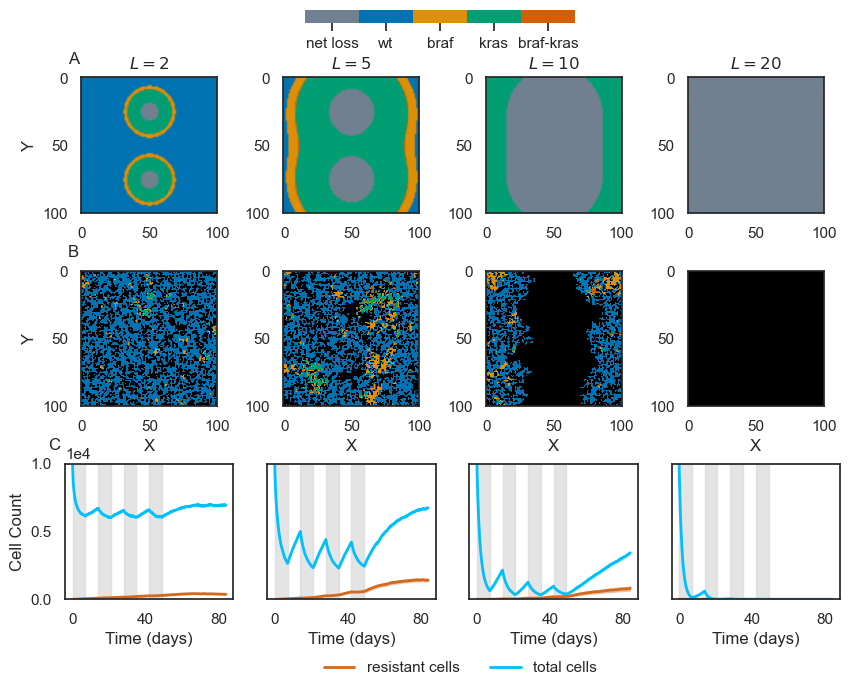

In [ ]:
fig,ax_list = plt.subplots(ncols=len(char_length),nrows=3,figsize=(10,6))

total_cells_list = []
resistant_cells_list = []

for i,cl in enumerate(char_length):
    ax = ax_list[0,i]
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    # load the diffGrid

    diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
    diffGrid = pd.read_csv(diffGridFile)
    img_t = np.zeros((100,100))

    img_t[diffGrid['x'],diffGrid['y']] = diffGrid['field']*drug_conc_scale

    diffImg = img_t
    msw = get_most_fit_at_conc(img_t)

    msw[img_t>1] = -1

    ax.imshow(msw,cmap=cmap_msw,vmin=-1,vmax=3,
              interpolation='gaussian',interpolation_stage='rgba')

    ax = ax_list[1,i]

    dataFile = dataDir + '/RepId_0_popGrid.csv'
    data = pd.read_csv(dataFile)
    img_t = np.ones((100,100))*-1
    img_t[data['x'],data['y']] = data['genotype']
    
    ax.imshow(img_t,cmap=cmap_agent,vmin=-1,vmax=3)

    ax = ax_list[2,i]
    counts_dict = {}

    for j in range(n_replicates):
        dataFile = dataDir + '/RepId_{}.csv'.format(j)
        data = pd.read_csv(dataFile)
        time = np.array(data["Time"])

        gen_indx = 0
        for col in data.columns[3:7]:
            ts = data[col]

            if gen_indx not in counts_dict:
                counts_dict[gen_indx] = np.array([ts])
            else:
                counts_dict[gen_indx] = np.append(counts_dict[gen_indx],np.array([ts]),axis=0)

            gen_indx += 1
    
    count_list = []
    # total_cells = np.zeros(data['Time'].shape)
    # resistant_cells = np.zeros(data['Time'].shape)
    wt_cells = []
    resistant_cells = [] # t by n array

    for j in range(n_replicates):
        resistant_cells_t = np.zeros(data['Time'].shape)
        for gen_indx in counts_dict.keys():
            ts = counts_dict[gen_indx][j]
            if gen_indx == 0:
                wt_cells.append(ts)
            else:
                # resistant_cells.append(ts)
                resistant_cells_t += ts
        resistant_cells.append(resistant_cells_t)
        

    
    wt_cells = np.array(wt_cells)
    resistant_cells = np.array(resistant_cells)

    total_cells = wt_cells + resistant_cells

    resistant_cells_mean = np.nanmean(resistant_cells,axis=0)
    resistant_cells_err = np.nanstd(resistant_cells,axis=0)/np.sqrt(n_replicates)

    ax.plot(data['Time'],resistant_cells_mean,linewidth=2,color='chocolate',label='resistant cells')
    ax.fill_between(data['Time'],resistant_cells_mean-resistant_cells_err,resistant_cells_mean+resistant_cells_err,alpha=0.3,color='chocolate')
    
    total_cells_mean = np.nanmean(total_cells,axis=0)
    total_cells_err = np.nanstd(total_cells,axis=0)/np.sqrt(n_replicates)

    ax.plot(data['Time'],total_cells_mean,linewidth=2,color='deepskyblue',label='total cells')
    ax.fill_between(data['Time'],total_cells_mean-total_cells_err,total_cells_mean+total_cells_err,alpha=0.3,color='deepskyblue')

    # fill vertically when the drug is on
    time = np.array(data['Time'])
    for t_start in np.arange(0,drugStopTime,pulse_interval):
        t_end = t_start + pulse_duration
        ax.fill_between([t_start,t_end],[-100,-100],[10000,10000],color='lightgrey',alpha=0.6)
    
    ax.set_ylim([-10,10**4])
    time = np.array(data['Time'])
    ax.set_xticks(np.arange(0,np.max(time),40*24))
    ax.set_xticklabels((np.arange(0,np.max(time),40*24)/24).astype(int))
    ax.set_xlabel('Time (days)')

ax_list[1,0].set_ylabel('Y')
ax_list[0,0].set_ylabel('Y')

for ax in ax_list[1,:]:
    ax.set_xlabel('X')

for ax in ax_list.flatten()[0:8]:
    ax.set_xticks([0,50,100])
    ax.set_yticks([0,50,100])

cbar_ax = fig.add_axes([0.25, 0.97, 0.5, 0.15])

norm = plt.Normalize(vmin=-1, vmax=3)
scalar_mappable = cm.ScalarMappable(cmap=cmap_msw, norm=norm)
scalar_mappable.set_array([])

cbar = plt.colorbar(scalar_mappable, ticks=[-0.6,.2,1,1.8,2.6], ax=cbar_ax, 
                    orientation='horizontal')

cbar.set_ticklabels(['net loss','wt','braf','kras','braf-kras'])
cbar.outline.set_visible(False)
cbar_ax.set_visible(False)

# shift rows 1 and 2 down
for row in [1,2]:
    for ax in ax_list[row,:]:
        pos = ax.get_position()
        pos.y0 -= 0.05*row
        pos.y1 -= 0.05*row
        ax.set_position(pos)

ax_list[2,0].set_ylabel('Cell Count')
ax_list[2,0].ticklabel_format(axis='y',style='sci',scilimits=(0,0))

for ax in ax_list[2,1:]:
    ax.set_yticks([])

# fig.tight_layout()
ax_list[2,1].legend(frameon=False,loc=(0.3,-0.6),ncol=2)

ax_list[0,0].annotate('A',(-0.1,1.1),xycoords='axes fraction',fontsize=12)

ax_list[1,0].annotate('B',(-0.1,1.1),xycoords='axes fraction',fontsize=12)

ax_list[2,0].annotate('C',(-0.1,1.1),xycoords='axes fraction',fontsize=12)


for i,ax in enumerate(ax_list[0,:]):
    cl = char_length[i]
    ax.set_title('$L = {}$'.format(cl))

fig.savefig('./figures/pc9_pulse_dosing_dense_grid.pdf',bbox_inches='tight')

In [ ]:
# initialize simulations as a dense grid for supplemental figure

n_replicates = 10

char_length = [2,5,10,20]

data_folder = "./data/pc9_pulse_dosing_dense_grid_no_het/" + date_str

indx = 0

for cl in char_length:

    modelConfigDic = {"xDim":100,"yDim":100,"nTSteps":nTSteps,"saveModelState":True,
                    "imageFrequency":-1,"nReplicates":n_replicates,
                    "dt":dt,"initialGeometry":"square","initialDensity":1,
                    # "initialWidth":10,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
                    "threeParamHill":False,"dieProb":0.025,"drugConcScale":drug_conc_scale,
                    "mutProb":0.001,
                    "staticGrid":True,"srcConc":10,"charLength":cl,
                    "pulseDosing":True,"staticGrid":True,"pMutant":0,
                    # "pulseDuration":24*3,"useMaxConc":True
                    "pulseDuration":pulse_duration,"pulseInterval":pulse_interval,
                    "useMaxConc":True,"drugStopTime":drugStopTime}
    
    # make sure each key is unique


    dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
    imgDir = "./data/doseResponseImages"

    myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
    myModel.Simulate()
    indx += 1

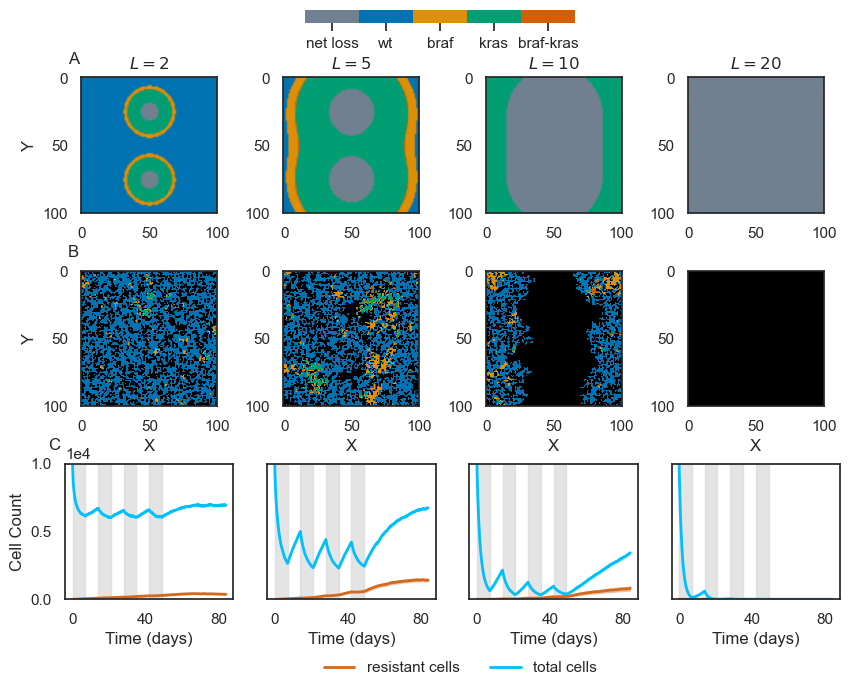

In [ ]:
fig,ax_list = plt.subplots(ncols=len(char_length),nrows=3,figsize=(10,6))

total_cells_list = []
resistant_cells_list = []

for i,cl in enumerate(char_length):
    ax = ax_list[0,i]
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    # load the diffGrid

    diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
    diffGrid = pd.read_csv(diffGridFile)
    img_t = np.zeros((100,100))

    img_t[diffGrid['x'],diffGrid['y']] = diffGrid['field']*drug_conc_scale

    diffImg = img_t
    msw = get_most_fit_at_conc(img_t)

    msw[img_t>1] = -1

    ax.imshow(msw,cmap=cmap_msw,vmin=-1,vmax=3,
              interpolation='gaussian',interpolation_stage='rgba')

    ax = ax_list[1,i]

    dataFile = dataDir + '/RepId_0_popGrid.csv'
    data = pd.read_csv(dataFile)
    img_t = np.ones((100,100))*-1
    img_t[data['x'],data['y']] = data['genotype']
    
    ax.imshow(img_t,cmap=cmap_agent,vmin=-1,vmax=3)

    ax = ax_list[2,i]
    counts_dict = {}

    for j in range(n_replicates):
        dataFile = dataDir + '/RepId_{}.csv'.format(j)
        data = pd.read_csv(dataFile)
        time = np.array(data["Time"])

        gen_indx = 0
        for col in data.columns[3:7]:
            ts = data[col]

            if gen_indx not in counts_dict:
                counts_dict[gen_indx] = np.array([ts])
            else:
                counts_dict[gen_indx] = np.append(counts_dict[gen_indx],np.array([ts]),axis=0)

            gen_indx += 1
    
    count_list = []
    # total_cells = np.zeros(data['Time'].shape)
    # resistant_cells = np.zeros(data['Time'].shape)
    wt_cells = []
    resistant_cells = [] # t by n array

    for j in range(n_replicates):
        resistant_cells_t = np.zeros(data['Time'].shape)
        for gen_indx in counts_dict.keys():
            ts = counts_dict[gen_indx][j]
            if gen_indx == 0:
                wt_cells.append(ts)
            else:
                # resistant_cells.append(ts)
                resistant_cells_t += ts
        resistant_cells.append(resistant_cells_t)
        

    
    wt_cells = np.array(wt_cells)
    resistant_cells = np.array(resistant_cells)

    total_cells = wt_cells + resistant_cells

    resistant_cells_mean = np.nanmean(resistant_cells,axis=0)
    resistant_cells_err = np.nanstd(resistant_cells,axis=0)/np.sqrt(n_replicates)

    ax.plot(data['Time'],resistant_cells_mean,linewidth=2,color='chocolate',label='resistant cells')
    ax.fill_between(data['Time'],resistant_cells_mean-resistant_cells_err,resistant_cells_mean+resistant_cells_err,alpha=0.3,color='chocolate')
    
    total_cells_mean = np.nanmean(total_cells,axis=0)
    total_cells_err = np.nanstd(total_cells,axis=0)/np.sqrt(n_replicates)

    ax.plot(data['Time'],total_cells_mean,linewidth=2,color='deepskyblue',label='total cells')
    ax.fill_between(data['Time'],total_cells_mean-total_cells_err,total_cells_mean+total_cells_err,alpha=0.3,color='deepskyblue')

    # fill vertically when the drug is on
    time = np.array(data['Time'])
    for t_start in np.arange(0,drugStopTime,pulse_interval):
        t_end = t_start + pulse_duration
        ax.fill_between([t_start,t_end],[-100,-100],[10000,10000],color='lightgrey',alpha=0.6)
    
    ax.set_ylim([-10,10**4])
    time = np.array(data['Time'])
    ax.set_xticks(np.arange(0,np.max(time),40*24))
    ax.set_xticklabels((np.arange(0,np.max(time),40*24)/24).astype(int))
    ax.set_xlabel('Time (days)')

ax_list[1,0].set_ylabel('Y')
ax_list[0,0].set_ylabel('Y')

for ax in ax_list[1,:]:
    ax.set_xlabel('X')

for ax in ax_list.flatten()[0:8]:
    ax.set_xticks([0,50,100])
    ax.set_yticks([0,50,100])

cbar_ax = fig.add_axes([0.25, 0.97, 0.5, 0.15])

norm = plt.Normalize(vmin=-1, vmax=3)
scalar_mappable = cm.ScalarMappable(cmap=cmap_msw, norm=norm)
scalar_mappable.set_array([])

cbar = plt.colorbar(scalar_mappable, ticks=[-0.6,.2,1,1.8,2.6], ax=cbar_ax, 
                    orientation='horizontal')

cbar.set_ticklabels(['net loss','wt','braf','kras','braf-kras'])
cbar.outline.set_visible(False)
cbar_ax.set_visible(False)

# shift rows 1 and 2 down
for row in [1,2]:
    for ax in ax_list[row,:]:
        pos = ax.get_position()
        pos.y0 -= 0.05*row
        pos.y1 -= 0.05*row
        ax.set_position(pos)

ax_list[2,0].set_ylabel('Cell Count')
ax_list[2,0].ticklabel_format(axis='y',style='sci',scilimits=(0,0))

for ax in ax_list[2,1:]:
    ax.set_yticks([])

# fig.tight_layout()
ax_list[2,1].legend(frameon=False,loc=(0.3,-0.6),ncol=2)

ax_list[0,0].annotate('A',(-0.1,1.1),xycoords='axes fraction',fontsize=12)

ax_list[1,0].annotate('B',(-0.1,1.1),xycoords='axes fraction',fontsize=12)

ax_list[2,0].annotate('C',(-0.1,1.1),xycoords='axes fraction',fontsize=12)


for i,ax in enumerate(ax_list[0,:]):
    cl = char_length[i]
    ax.set_title('$L = {}$'.format(cl))

fig.savefig('./figures/pc9_pulse_dosing_dense_grid_no_het.pdf',bbox_inches='tight')